## Multi-dimensional 0-1 knapsack problem
The solution is encoded as array of length NUM_ITEMS, where each cell is an item and the value inside represents the specific knapsack it's been assigned (from 0 to NUM_KNAPSACK-1) to or -1 if unassigned.

In [119]:
import numpy as np
from tqdm.notebook import tqdm
from icecream import ic
import math
import matplotlib.pyplot as plt

In [120]:
NUM_KNAPSACKS = 2
NUM_ITEMS = 10
NUM_DIMENSIONS = 2

In [121]:
MAX_STEPS = 10000

In [122]:
VALUES = np.random.randint(0, 100, size=NUM_ITEMS)
WEIGHTS = np.random.randint(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = np.random.randint(0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

In [123]:
""" Check if a solution satisfies all constraints """
def valid_solution(solution):
    for kp in range(NUM_KNAPSACKS):
        if np.any(WEIGHTS[solution == kp].sum(axis = 0) > CONSTRAINTS[kp]):
            return False
    return True

In [124]:
""" Fitness function: sum of values of items in knapsacks if valid """
def fitness(solution):
    return np.sum(VALUES[solution >= 0])

In [125]:
""" Tweak function: move one item to a different knapsack or unassign it"""
def tweak(solution):
    new_solution = solution.copy()
    # Choose a random item
    i = np.random.randint(0, NUM_ITEMS)
    solution_representations = np.arange(-1, NUM_KNAPSACKS)
    # Choose a new knapsack for the item OR unassign it
    new_value = np.random.choice(solution_representations)
    while new_value == solution[i]:
        new_value = np.random.choice(solution_representations)
    new_solution[i] = new_value
    # If we unassigned an item, assign the backpack to a random unassigned item (if any)
    if new_value == -1:
        old_value = solution[i]
        unassigned_items = np.arange(NUM_ITEMS)[solution == -1]
        if len(unassigned_items) >= 1:
            j = np.random.choice(unassigned_items)
            new_solution[j] = old_value
    return new_solution

In [126]:
""" Class to store experiment results and plot fitness over time """
class ExperimentResult:
    def __init__(self, name):
        self.name = name
        self.fitness_history = []
        self.best_solution = None
        self.best_fitness = -1
        self.restarts = []
    
    def add_fitness(self, fitness, solution):
        self.fitness_history.append(fitness)
        if fitness > self.best_fitness:
            self.best_fitness = fitness
            self.best_solution = solution.copy()
    
    def plot_fitness(self):
        fig, ax = plt.subplots()
        ax.plot(self.fitness_history)
        if len(self.restarts) > 0:
            for r in self.restarts:
                ax.axvline(r, color='red', linestyle='--', alpha=0.5)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Fitness")
        ax.set_title(self.name)
        ax.set_xlim(0, len(self.fitness_history))
        ax.set_ylim(0, np.sum(VALUES) * 1.1)
        ax.axhline(np.sum(VALUES), color='green', linestyle='--', alpha=0.5, label='Total maximum value')
        ax.legend(loc="lower right")
        plt.show()
        return ax
    
    def __str__(self):
        header = f"Experiment: {self.name}\n"
        best = f"Best Fitness: {self.best_fitness}\n"
        for k in range(NUM_KNAPSACKS):
            best += f" Knapsack {k}: items {np.where(self.best_solution == k)[0].tolist()}\n"
        best += f" Unassigned items: {np.where(self.best_solution == -1)[0].tolist()}\n"
        return header + best

In [127]:
""" Simulated Annealing algorithm """
def simulatedAnnealing():
    # start from a valid solution where no items are assigned
    current_solution = np.full(NUM_ITEMS, -1)
    current_obj = fitness(current_solution)
    best_solution = current_solution 
    best_obj = current_obj 
    results = ExperimentResult("Simulated Annealing")
    results.add_fitness(current_obj, current_solution)
    temp = 100
    initial_temp = temp
    for step in tqdm(range(MAX_STEPS)):
        new_solution = tweak(current_solution)
        new_obj = fitness(new_solution)
        if valid_solution(new_solution):
            if new_obj >= current_obj:
                current_solution = new_solution
                current_obj = new_obj            
                if new_obj > best_obj:
                    best_solution = new_solution
                    best_obj = new_obj
                
            else:
                diff = new_obj - current_obj
                p = math.exp(diff / temp)

                if np.random.rand() < p:
                    current_solution = new_solution
                    current_obj = new_obj
        temp *= 0.99
        results.add_fitness(current_obj, current_solution)
    return results
        


## TEST PROBLEMS

In [128]:
# Problem 1:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

  0%|          | 0/10000 [00:00<?, ?it/s]

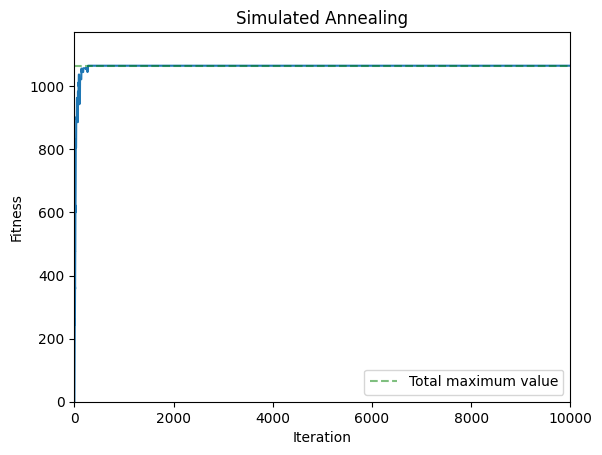

Experiment: Simulated Annealing
Best Fitness: 1065
 Knapsack 0: items [0, 2, 7, 9, 11, 12, 14, 15, 16]
 Knapsack 1: items [1, 3, 4, 6, 10, 13, 17]
 Knapsack 2: items [5, 8, 18, 19]
 Unassigned items: []



In [129]:
results = simulatedAnnealing()
results.plot_fitness()
print(results)

In [130]:
# Problem 2:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 10
NUM_ITEMS = 100
NUM_DIMENSIONS = 10
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS,size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

  0%|          | 0/10000 [00:00<?, ?it/s]

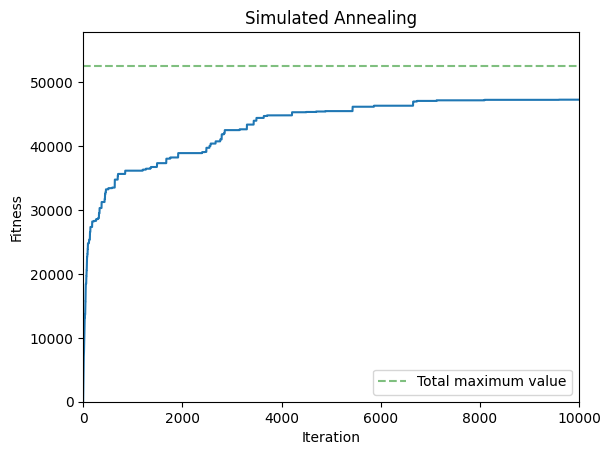

Experiment: Simulated Annealing
Best Fitness: 47302
 Knapsack 0: items [19, 23, 39, 43, 86, 88]
 Knapsack 1: items [21, 29, 33, 42, 47, 77, 89, 95, 99]
 Knapsack 2: items [36, 50, 62, 69, 73, 80]
 Knapsack 3: items [9, 24, 27, 32, 48, 72, 84, 85, 92]
 Knapsack 4: items [5, 7, 20, 41, 58, 66, 81, 87, 90, 93, 97]
 Knapsack 5: items [15, 18, 28, 53, 60, 65, 79, 83, 94]
 Knapsack 6: items [2, 11, 16, 22, 38, 45, 46]
 Knapsack 7: items [14, 31, 40, 56, 59, 74, 98]
 Knapsack 8: items [1, 10, 12, 37, 64, 78]
 Knapsack 9: items [13, 17, 25, 34, 49, 61, 63, 70, 91]
 Unassigned items: [0, 3, 4, 6, 8, 26, 30, 35, 44, 51, 52, 54, 55, 57, 67, 68, 71, 75, 76, 82, 96]



In [131]:
results = simulatedAnnealing()
results.plot_fitness()
print(results)

In [132]:
# Problem 3:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 100
NUM_ITEMS = 5000
NUM_DIMENSIONS = 100
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(1000 * 10, 1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

  0%|          | 0/10000 [00:00<?, ?it/s]

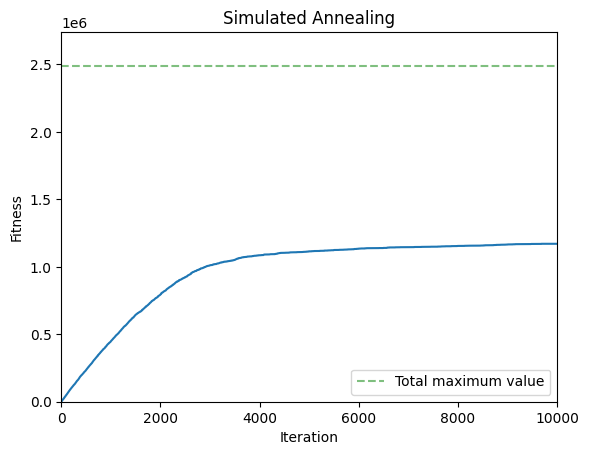

Experiment: Simulated Annealing
Best Fitness: 1170705
 Knapsack 0: items [72, 697, 1066, 1103, 1294, 1710, 1835, 1903, 1929, 1944, 2130, 2151, 2379, 2696, 3018, 3246, 3322, 3469, 3564, 3622, 3684, 3746, 3882, 4077, 4112]
 Knapsack 1: items [13, 139, 395, 568, 769, 1214, 1346, 1587, 1975, 2068, 2503, 2544, 2779, 2994, 3163, 3532, 3552, 3640, 3916, 4147, 4272, 4358]
 Knapsack 2: items [330, 1474, 1513, 1635, 1691, 1886, 2477, 2498, 3079, 3177, 3272, 3499, 3542, 3792, 4151, 4190, 4303, 4453, 4547, 4860]
 Knapsack 3: items [280, 518, 542, 756, 974, 1153, 1190, 1194, 1683, 2138, 2242, 2425, 2437, 2761, 2993, 3089, 3113, 3663, 3772, 3907, 4342, 4370, 4459, 4610]
 Knapsack 4: items [286, 660, 764, 787, 794, 827, 1111, 1145, 1240, 1550, 1686, 1842, 2076, 2407, 2542, 2853, 2862, 3116, 3321, 3915, 4360, 4422, 4424]
 Knapsack 5: items [39, 582, 951, 1187, 1508, 1785, 1968, 2000, 2175, 2658, 2676, 2888, 3359, 3482, 3607, 3721, 3733, 4413, 4691, 4836, 4968, 4991]
 Knapsack 6: items [60, 116, 435, 1

In [133]:
results = simulatedAnnealing()
results.plot_fitness()
print(results)